In [2]:
# location of the data set. Name files with year
fileLocation = '/Code/spark/LAB4/data/200*.csv'

# number of trees in forest
nbrOfTreesInForest = [4, 8, 16]

In [17]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
# Create spark session
spark = SparkSession.builder.appName("theappname").getOrCreate()
# Load data from files
df = spark.read.csv(fileLocation, mode="DROPMALFORMED", inferSchema=True, header = True)

# During debug just load a fraction of the sample dataset to reduce computing time
df = df.sample(fraction=0.01)

from pyspark.sql.functions import  length, lpad
from pyspark.sql.types import IntegerType
# Do first filtering 
selection = df\
    .where((df.Diverted == 0) & (df.CancellationCode.isNull()) & (df.TailNum.rlike("^([A-Z]|[a-z]|[0-9])"
                                                                                                                  "+$")) & ((length(df.DepTime) == 4) | (length(df.DepTime) == 3)) & (length(df.ArrTime) == 4) | (length(df.ArrTime) == 3))\
    .where(df['TailNum'].isNotNull())\
    .withColumn("DepTime", when(length(df.DepTime) == 3, lpad(df['DepTime'], 4,'0')).otherwise(df['DepTime']))\
    .withColumn("ArrTime", when(length(df.ArrTime) == 3, lpad(df['ArrTime'], 4,'0')).otherwise(df['ArrTime']))\
    .sort(asc('Year'), 'Month', 'DayofMonth', 'ArrTime')\
    .withColumn("ArrDelay", df.ArrDelay.cast(IntegerType()))\
    .withColumn("DepDelay", df["DepDelay"].cast(IntegerType()))\
    .withColumn("CarrierDelay", df["CarrierDelay"].cast(IntegerType()))\
    .withColumn("WeatherDelay", df["WeatherDelay"].cast(IntegerType()))\
    .withColumn("NASDelay", df["NASDelay"].cast(IntegerType()))\
    .withColumn("SecurityDelay", df["SecurityDelay"].cast(IntegerType()))\
    .withColumn("LateAircraftDelay", df["LateAircraftDelay"].cast(IntegerType()))\
    .fillna(0, subset=['ArrDelay', 'DepDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay' ])

from pyspark.sql.types import BinaryType

# Define the FFA (Federal Aviation Administration) function
udf(returnType=BinaryType())
IsLate  = lambda x : x["ArrDelay"] > 15

# Create a new column 'IsLate' stating that the flight was considered delay or not
selection = selection\
    .withColumn("IsLate", (IsLate(selection)))

In [18]:
# convert to pandas since we a running on a single node and the fact that I wanted to learn about pandas
basePanda = selection.toPandas()

# remove the dataframe from memory
selection.unpersist()


DataFrame[Year: int, Month: int, DayofMonth: int, DayOfWeek: int, DepTime: string, CRSDepTime: int, ArrTime: string, CRSArrTime: int, UniqueCarrier: string, FlightNum: int, TailNum: string, ActualElapsedTime: string, CRSElapsedTime: string, AirTime: string, ArrDelay: int, DepDelay: int, Origin: string, Dest: string, Distance: int, TaxiIn: string, TaxiOut: string, Cancelled: int, CancellationCode: string, Diverted: int, CarrierDelay: int, WeatherDelay: int, NASDelay: int, SecurityDelay: int, LateAircraftDelay: int, IsLate: boolean]

In [19]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode test columns into new ones and drop the original 
lb_make = LabelEncoder()
basePanda['Origin_code'] = lb_make.fit_transform (basePanda['Origin'])
basePanda['Dest_code'] = lb_make.fit_transform (basePanda['Dest'])
basePanda['UniqueCarrier_code'] = lb_make.fit_transform (basePanda['UniqueCarrier'])
basePanda['TailNum_code'] = lb_make.fit_transform (basePanda['TailNum'])
basePanda['DepTime_code'] = lb_make.fit_transform (basePanda['DepTime'])
basePanda['TaxiOut_code'] = lb_make.fit_transform (basePanda['TaxiOut'])
basePanda['DepTimeHour'] = lb_make.fit_transform (basePanda['DepTime'].str[0:2])    
basePanda = basePanda.drop('Origin', axis = 1) 
basePanda = basePanda.drop('Dest', axis = 1)
basePanda = basePanda.drop('UniqueCarrier', axis = 1) 
basePanda = basePanda.drop('TailNum', axis = 1) 
basePanda = basePanda.drop('CancellationCode', axis = 1)
basePanda = basePanda.drop('Cancelled', axis = 1)
basePanda = basePanda.drop('ArrTime', axis = 1)
basePanda = basePanda.drop('DepTime', axis = 1)
basePanda = basePanda.drop('TaxiOut', axis = 1)
basePanda = basePanda.drop('ActualElapsedTime', axis = 1)
basePanda = basePanda.drop('CRSElapsedTime', axis = 1)
basePanda = basePanda.drop('AirTime', axis = 1)
basePanda = basePanda.drop('TaxiIn', axis = 1)
# extract the labels column to a separate panda and convert to numpy array
labelsPanda  = basePanda['IsLate']
labels = np.array(labelsPanda)
features = basePanda.drop('IsLate', axis = 1) 

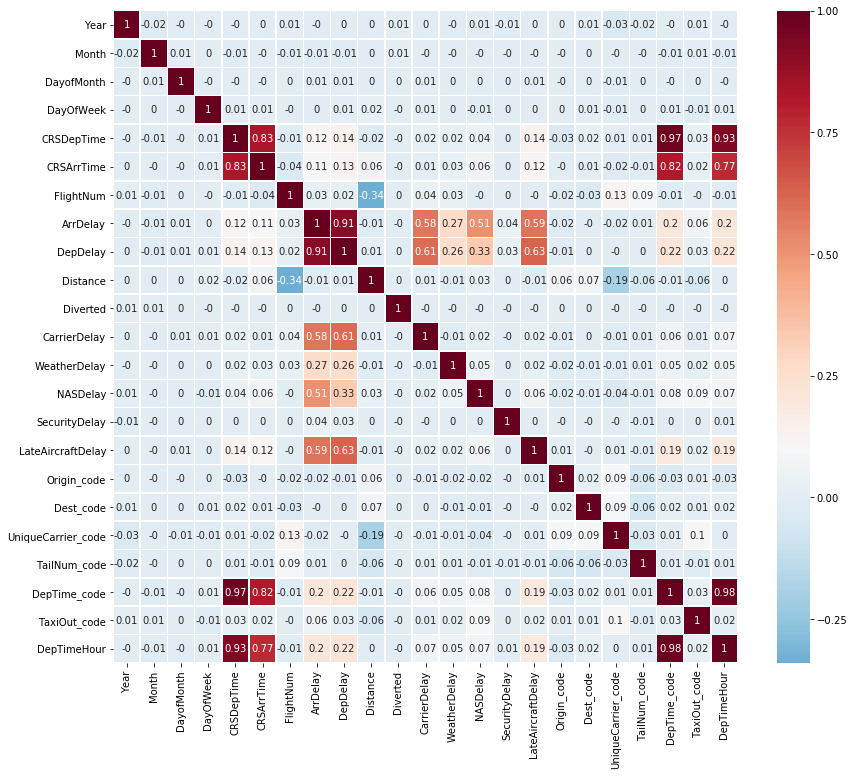

CRSDepTime           0.12
CRSArrTime           0.11
ArrDelay             1.00
DepDelay             0.91
CarrierDelay         0.58
WeatherDelay         0.27
NASDelay             0.51
LateAircraftDelay    0.59
DepTime_code         0.20
DepTimeHour          0.20
Name: ArrDelay, dtype: float64


In [20]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
corr = features.corr()
corr = corr.round(2)
plt.figure(figsize=(14,12))
sb.heatmap(corr, annot=True, cmap='RdBu_r', linewidth=0.5, center=0.1)
plt.savefig('heatmap.png',  dpi=100)
plt.show()

corr_target= np.abs(corr["ArrDelay"])
# Select the features with a correlation_target larger than 0.1
# The 0.1 might be a bit low but as the number of features is low 
# We can be a bit greedy and select a low limit (many features)
selected_features_filter_method= corr_target[corr_target>0.1]

print(selected_features_filter_method)

In [21]:
# Drop the ArrDelay as we do not need anymore
features = features.drop('ArrDelay', axis = 1)

# Start the forward selection from 
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

sfs = SFS(LinearRegression(),
           k_features=6,
           forward=True)

sfs.fit(features, labels)

('DepDelay',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'LateAircraftDelay',
 'DepTime_code')

In [22]:
selected_features_forward_selection = list(sfs.k_feature_names_)
print("Features selected by forward selection")
print(selected_features_forward_selection)

Feature selected by forward selection
['DepDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay', 'DepTime_code']


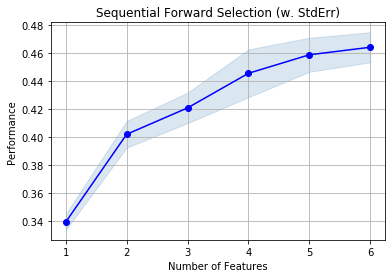

In [23]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.savefig('sfs.png')
plt.show()

In [24]:
# Convert from pandas to array to match the 'train_test_split' method
reduced_features = np.array(features[selected_features_forward_selection])

# split the features/labels into train and test sets 
train_features, test_features, train_labels, test_labels = train_test_split(reduced_features, labels, test_size = 0.25, random_state = 42)

In [13]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

def run_random_forest(tree_size):
    print('Fitting random forest model with {} trees'.format(tree_size))
    # Instantiate model with 4 decision trees
    rf = RandomForestClassifier(n_estimators = tree_size)
    # Train the model on training data
    rf.fit(train_features, train_labels);
    print("Random forest score: {:.4f} ".format(rf.score(test_features, test_labels)))
    
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features)
    
    print(classification_report(test_labels, predictions, target_names=['Not late','Late'], digits=4))
    
    # calculate the probalistics
    rf_probs = rf.predict_proba(test_features)[:, 1]
    # calculate the roc auc score to se the performance of the DR
    roc_value = roc_auc_score(test_labels, rf_probs)
    
    print("AUC ROC score: {:.4f} ".format(roc_value))
    print("-----------------------------------------------------")

for tree_size in nbrOfTreesInForest:
    run_random_forest(tree_size)

Fitting random forest model with 4 trees
Random forest score: 0.9984 
              precision    recall  f1-score   support

    Not late     0.9989    0.9991    0.9990     40866
        Late     0.9967    0.9959    0.9963     11324

    accuracy                         0.9984     52190
   macro avg     0.9978    0.9975    0.9977     52190
weighted avg     0.9984    0.9984    0.9984     52190

AUC ROC score: 0.9994 
-----------------------------------------------------
Fitting random forest model with 8 trees
Random forest score: 0.9987 
              precision    recall  f1-score   support

    Not late     0.9994    0.9990    0.9992     40866
        Late     0.9963    0.9978    0.9970     11324

    accuracy                         0.9987     52190
   macro avg     0.9978    0.9984    0.9981     52190
weighted avg     0.9987    0.9987    0.9987     52190

AUC ROC score: 0.9996 
-----------------------------------------------------
Fitting random forest model with 16 trees
Random for